In [2]:
import pandas as pd
from pathlib import Path

In [15]:
from pathlib import Path
import pandas as pd

path = Path("/Users/wangxinyuan/Desktop/Frechette_2003a_data.txt")

# Find the header row (first nonempty line with many tokens and no colons)
lines = path.read_text(encoding="utf-8", errors="ignore").splitlines()
hdr = None
for i, ln in enumerate(lines):
    if ":" in ln or ln.strip().startswith("*") or not ln.strip():
        continue
    if len(ln.split()) >= 8:
        hdr = i
        break
assert hdr is not None, "Couldn't locate header row—open the file and tell me which line has the column names."

colnames = lines[hdr].split()

df = pd.read_csv(
    path,
    sep=r"\s+",
    engine="python",
    header=None,          # we supply names
    names=colnames,
    skiprows=hdr+1,       # start right after the header
    on_bad_lines="skip",
)
import re
import numpy as np
import pandas as pd
from pathlib import Path

# --- 0) Helper to find a column by aliases (case-insensitive) -----------------
def find_col(df, aliases):
    aliases = [a.lower() for a in aliases]
    for c in df.columns:
        cl = c.strip().lower()
        if cl in aliases:
            return c
    return None

# Try to detect canonical columns by common aliases seen in this dataset
col_round    = find_col(df, ["round","round_in_election","rnd","period"])
col_election = find_col(df, ["election","elect","el"])
col_open     = find_col(df, ["open","rule_open","treatment","rule"])
col_session  = find_col(df, ["session","session_id","sess"])

# Payoff columns: prefer amflo1..amflo5; else prop1..prop5
pay_cols = [c for c in df.columns if re.fullmatch(r"amflo[1-5]", c, flags=re.I)]
if len(pay_cols) != 5:
    alt = [c for c in df.columns if re.fullmatch(r"prop[1-5]", c, flags=re.I)]
    if len(alt) == 5:
        pay_cols = alt

# Sanity checks (print what we found)
print("Detected columns:")
print({"round": col_round, "election": col_election, "open": col_open, "session": col_session, "pay_cols": pay_cols})

assert col_round is not None,  "Couldn't find a 'round' column (looked for round/round_in_election/rnd/period)."
assert col_election is not None, "Couldn't find an 'election' column."
assert col_open is not None,   "Couldn't find an 'open' (rule) column."
assert len(pay_cols) == 5,     f"Couldn't find 5 payoff columns; found {pay_cols}"

# --- 1) Build a trimmed table with only relevant columns ----------------------
keep_cols = [x for x in [col_session, col_election, col_round, col_open] if x is not None] + pay_cols
mini = df[keep_cols].copy()

# Coerce types we depend on
mini[col_round]    = pd.to_numeric(mini[col_round], errors="coerce")
mini[col_election] = pd.to_numeric(mini[col_election], errors="coerce")
mini[col_open]     = pd.to_numeric(mini[col_open], errors="coerce")

for c in pay_cols:
    mini[c] = pd.to_numeric(mini[c], errors="coerce")

# --- 2) Keep only Round == 1 rows --------------------------------------------
round1 = mini.loc[mini[col_round] == 1].copy()

# --- 3) Optional: rescale offers to dollars if they look normalized (0–1) ----
if round1[pay_cols].max().max() <= 2:   # heuristic
    round1[pay_cols] = round1[pay_cols] * 10

# --- 4) Show and save ---------------------------------------------------------
print("Round=1 shape:", round1.shape)
print(round1.head(10).to_string(index=False))

out_path = Path("/Users/wangxinyuan/Desktop/Frechette_round1_only.csv")
round1.to_csv(out_path, index=False)
print("Saved:", out_path)

print(df.shape)
print(df.head(10))
print(df.columns.tolist())


Detected columns:
{'round': 'round', 'election': 'election', 'open': 'open', 'session': 'session', 'pay_cols': ['amflo1', 'amflo2', 'amflo3', 'amflo4', 'amflo5']}
Round=1 shape: (1000, 9)
session  election  round  open  amflo1  amflo2  amflo3  amflo4  amflo5
     ""       1.0      1   0.0     NaN     NaN     NaN     NaN     NaN
     ""       1.0      1   1.0     NaN     NaN     NaN     NaN     NaN
     ""       1.0      1   1.0     NaN     NaN     NaN     NaN     NaN
     ""       1.0      1   0.0     NaN     NaN     NaN     NaN     NaN
     ""       1.0      1   0.0     NaN     NaN     NaN     NaN     NaN
     ""       1.0      1   1.0     NaN     NaN     NaN     NaN     NaN
     ""       1.0      1   1.0     NaN     NaN     NaN     NaN     NaN
     ""       1.0      1   0.0     NaN     NaN     NaN     NaN     NaN
     ""       1.0      1   1.0     NaN     NaN     NaN     NaN     NaN
     ""       1.0      1   0.0     NaN     NaN     NaN     NaN     NaN
Saved: /Users/wangxinyuan/Deskt

In [16]:
import re
import numpy as np
import pandas as pd

# 1) Pick the columns we care about -------------------------------------------
# try to find the five payoff columns (usually amflo1..amflo5; fallback prop1..prop5)
pay_cols = [c for c in df.columns if re.fullmatch(r"amflo[1-5]", c)]
if len(pay_cols) != 5:
    alt = [c for c in df.columns if re.fullmatch(r"prop[1-5]", c)]
    if len(alt) == 5:
        pay_cols = alt
assert len(pay_cols) == 5, f"Couldn't find 5 payoff columns; found: {pay_cols}"

keep_cols = [c for c in ["session","election","round","open","proposer"] if c in df.columns] + pay_cols

# 2) Coerce types and filter to Round = 1 -------------------------------------
mini = df[keep_cols].copy()
mini["round"] = pd.to_numeric(mini["round"], errors="coerce")
mini["open"]  = pd.to_numeric(mini["open"],  errors="coerce")  # 1 = Open rule, 0 = Closed

round1 = mini.loc[mini["round"] == 1].copy()

# 3) (Optional) rescale offers if they look like 0–1 instead of $ (multiply by 10)
if round1[pay_cols].max().max() <= 2:
    round1[pay_cols] = round1[pay_cols] * 10

# 4) Inspect + save ------------------------------------------------------------
print("Round=1 shape:", round1.shape)
print(round1.head(10).to_string(index=False))

# Save a clean file with only round 1
out_path = Path("/Users/wangxinyuan/Desktop/Frechette_round1_only.csv")
round1.to_csv(out_path, index=False)
print("Saved:", out_path)


Round=1 shape: (1000, 10)
session election  round  open proposer  amflo1  amflo2  amflo3  amflo4  amflo5
     ""        1      1   0.0        0     NaN     NaN     NaN     NaN     NaN
     ""        1      1   1.0        0     NaN     NaN     NaN     NaN     NaN
     ""        1      1   1.0        0     NaN     NaN     NaN     NaN     NaN
     ""        1      1   0.0        0     NaN     NaN     NaN     NaN     NaN
     ""        1      1   0.0        0     NaN     NaN     NaN     NaN     NaN
     ""        1      1   1.0        0     NaN     NaN     NaN     NaN     NaN
     ""        1      1   1.0        0     NaN     NaN     NaN     NaN     NaN
     ""        1      1   0.0        0     NaN     NaN     NaN     NaN     NaN
     ""        1      1   1.0        0     NaN     NaN     NaN     NaN     NaN
     ""        1      1   0.0        0     NaN     NaN     NaN     NaN     NaN
Saved: /Users/wangxinyuan/Desktop/Frechette_round1_only.csv


In [7]:
df.to_csv("/Users/wangxinyuan/Desktop/Frechette_2003a_data.csv", index=False)

In [8]:
from pathlib import Path
import pandas as pd
import numpy as np

# --- 1) Read TXT from your Desktop and detect the header line ---
path = Path("/Users/wangxinyuan/Desktop/Frechette_2003a_data.txt")

lines = path.read_text(encoding="utf-8", errors="ignore").splitlines()
hdr = None
for i, ln in enumerate(lines):
    if ":" in ln or ln.strip().startswith("*") or not ln.strip():
        continue
    if len(ln.split()) >= 8:       # first substantial non-comment line
        hdr = i
        break
assert hdr is not None, "Couldn't locate header row; open the file and check the column-name line."

colnames = lines[hdr].split()

df = pd.read_csv(
    path,
    sep=r"\s+",
    engine="python",
    header=None,          # we'll use colnames we just parsed
    names=colnames,
    skiprows=hdr+1,
    on_bad_lines="skip",
)

# --- 2) Make it a tidy 'table' with clear types ---
# Coerce 'open' to numeric just in case
df["open"] = pd.to_numeric(df["open"], errors="coerce")

# If you only want the key analysis columns, keep a trimmed view (optional):
table = df.copy()  # or: df[["session","election","round","open","proposer","amflo1","amflo2","amflo3","amflo4","amflo5"]]

# --- 3) Filter by the 'open' column ---
# Open-rule rows (open == 1)
open_tbl = table[table["open"] == 1].copy()

# Closed-rule rows (open == 0)
closed_tbl = table[table["open"] == 0].copy()

# (Optional) Quick counts to confirm
print("Counts by rule (from 'open' column):")
print(table["open"].value_counts(dropna=False).rename({1.0:"Open", 0.0:"Closed"}))

# Peek at each filtered table
print("\nOpen-rule table preview:")
print(open_tbl.head(10))
print("\nClosed-rule table preview:")
print(closed_tbl.head(10))

# --- 4) (Optional) Save the tables as CSVs beside the source file ---
open_csv   = path.with_name("Frechette_open_only.csv")
closed_csv = path.with_name("Frechette_closed_only.csv")
table_csv  = path.with_name("Frechette_clean_full.csv")

open_tbl.to_csv(open_csv, index=False)
closed_tbl.to_csv(closed_csv, index=False)
table.to_csv(table_csv, index=False)

print(f"\nSaved:\n- {open_csv}\n- {closed_csv}\n- {table_csv}")


Counts by rule (from 'open' column):
open
Open      558
Closed    300
NaN       249
5.0        35
6.0        22
4.0        12
7.0         6
6.5         5
10.0        5
6.25        5
0.5         4
7.5         4
3.0         3
8.0         2
2.0         1
5.25        1
3.2         1
6.75        1
Name: count, dtype: int64

Open-rule table preview:
   election   id  subject  round  prop1  prop2  prop3 prop4  prop5 prop6  ...  \
1         1  "A"        2      1    2.0   10.0    5.0     3    5.0    10  ...   
2         1  "B"        4      1    5.0    5.0    3.0     7    5.0    10  ...   
5         1  "C"        5      1    5.0    7.0    4.0     2    7.0    10  ...   
6         1  "D"        1      1   10.0    0.0    8.0     0    7.0    10  ...   
8         1  "E"        6      1    5.0    5.0    5.0     5    5.0    10  ...   
10        1  "F"        3      1    5.0    5.0    8.0     2    5.0    10  ...   
12        2  "A"        5      1    5.0    3.0    4.0     3   10.0    12  ...   
14    

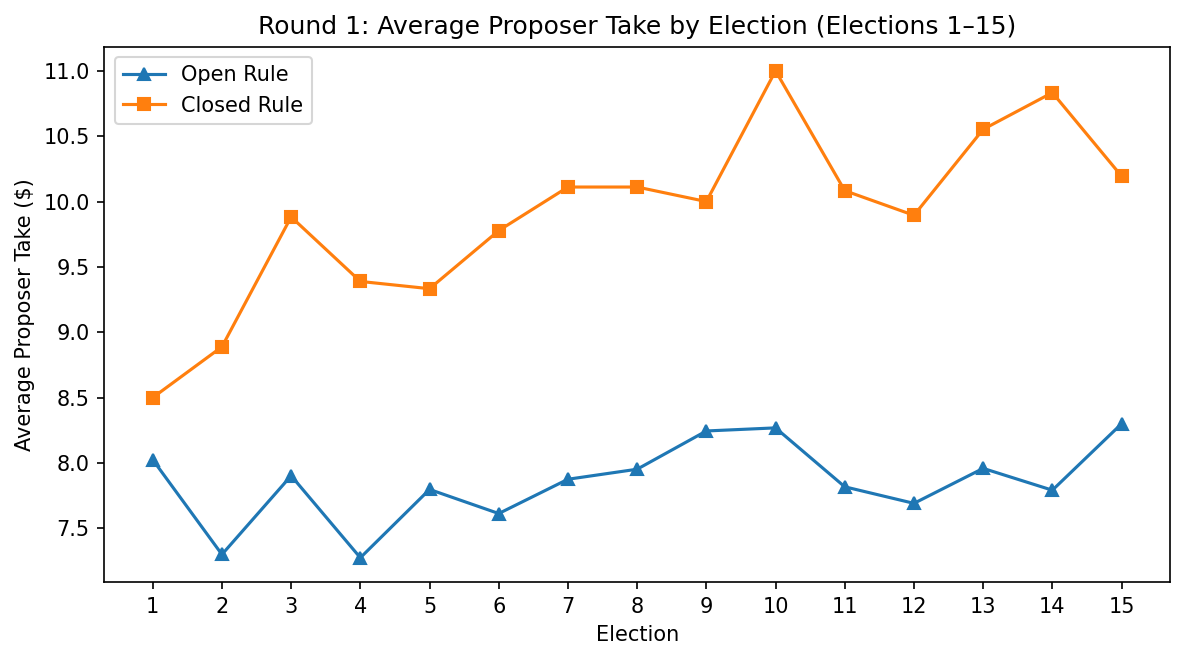

Saved → avg_proposer_take_round1_by_election_MAXprop_1to15.csv


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Choose the six proposal columns --------------------------------------
prop_cols = [f"prop{i}" for i in range(1, 7)]
missing = [c for c in prop_cols if c not in df.columns]
assert not missing, f"Missing columns: {missing}"

# Ensure key columns exist
assert "election" in df.columns, "Missing 'election' column"
assert "round"    in df.columns, "Missing 'round' column"
assert "open"     in df.columns, "Missing 'open' column"

# --- 2) Coerce numerics -------------------------------------------------------
for c in ["election","round","open"] + prop_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# --- 3) Optional: rescale to dollars if values look normalized (0–1) ---------
if np.nanmax(df[prop_cols].to_numpy()) <= 2:
    df[prop_cols] = df[prop_cols] * 10

# --- 4) Proposer's own take = row-wise MAX over prop1..prop6 ------------------
# Also record which slot (1..6) was the max, for debugging
df["proposer_take"] = df[prop_cols].max(axis=1, skipna=True)
df["proposer_slot"] = df[prop_cols].astype(float).idxmax(axis=1).str.extract(r"(\d+)").astype(float)

# --- 5) Round 1 only ----------------------------------------------------------
r1 = df[df["round"] == 1].copy()
r1["rule_label"] = np.where(r1["open"] == 1, "Open Rule", "Closed Rule")


# Ensure election is numeric, then cap to 1..15
r1["election"] = pd.to_numeric(r1["election"], errors="coerce")
r1_15 = r1[r1["election"].between(1, 15)].copy()

# Rebuild the summary on 1..15 only and reindex to show all elections even if missing
summary_15 = (
    r1_15.groupby(["election","rule_label"])["proposer_take"]
         .mean()
         .unstack("rule_label")
         .reindex(range(1, 16))   # forces rows 1..15 in order
)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4.5), dpi=150)
x = summary_15.index.to_numpy()
if "Closed Rule" in summary_15:
    plt.plot(x, summary_15["Closed Rule"], marker="^", linestyle="-", label="Open Rule")
if "Open Rule" in summary_15:
    plt.plot(x, summary_15["Open Rule"], marker="s", linestyle="-", label="Closed Rule")
plt.xlabel("Election")
plt.ylabel("Average Proposer Take ($)")
plt.title("Round 1: Average Proposer Take by Election (Elections 1–15)")
plt.xticks(range(1,16))
plt.legend()
plt.tight_layout()
plt.show()

# Save the restricted table
summary_15.round(3).to_csv("avg_proposer_take_round1_by_election_MAXprop_1to15.csv")
print("Saved → avg_proposer_take_round1_by_election_MAXprop_1to15.csv")
